<a href="https://colab.research.google.com/github/AdityaVerma2809/Data-Science-Club-Task/blob/main/Task_2_DSC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_recall_curve, auc, ConfusionMatrixDisplay

# STEP 1: CUSTOM TRANSFORMERS

In [2]:
class TextDistiller(BaseEstimator, TransformerMixin):
    """Removes boilerplate like headers, footers, and noise using structural analysis."""
    def fit(self, X, y=None): return self

    def transform(self, X):
        clean_text = []
        for text in X:
            text = re.sub(r'\S+@\S+', '', text)
            text = re.sub(r'http\S+', '', text)
            text = re.sub(r'(terms and conditions|all rights reserved|click here|contact us)', '', text, flags=re.I)
            text = re.sub(r'[^a-zA-Z0-9\s\.\,\?\!]', '', text)
            clean_text.append(text.strip())
        return clean_text



In [3]:
class ComplexityScorer(BaseEstimator, TransformerMixin):
    """Calculates Information Density via Type-to-Token Ratio (TTR)."""
    def fit(self, X, y=None): return self

    def transform(self, X):
        scores = []
        for text in X:
            tokens = text.lower().split()
            if len(tokens) == 0:
                scores.append([0])
                continue
            #TTR = Unique words / Total words , High TTR = Dense Information.
            ttr = len(set(tokens)) / len(tokens)
            scores.append([ttr])
        return np.array(scores)

# STEP 2: DATASET SIMULATION

MULTI-SOURCE DATASET (arXiv + UCI Spam)

In [4]:
!pip install arxiv praw

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 10.1 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6046 sha256=11a0abe54e9be26daa2243c85ee6004f83b4058d9d954afb3e4a3f73f2d68bb9
  Stored in directory: /root/.cache/pip/wheels/03/f5/1a/23761066dac1d0e8e683e5fdb27e12de53209d05a4a37e6246
Successfully built sgmllib3k


In [5]:
import arxiv
import pandas as pd
import numpy as np
import io
import requests

In [6]:
def fetch_arxiv_papers(max_results=800):
    """Scrapes high-quality research abstracts."""
    print(f"Scraping {max_results} research papers from arXiv...")
    client = arxiv.Client()
    # Pulling from AI and Systems to align with your EdgeRAG project
    search = arxiv.Search(query="cat:cs.AI OR cat:cs.LG OR cat:cs.OS", max_results=max_results)
    return [res.summary.replace('\n', ' ') for res in client.results(search)]

def fetch_spam_noise():
    """Downloads the UCI SMS Spam dataset for high-quality 'Junk' noise."""
    print("Downloading UCI Spam Dataset for noise class...")
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
    r = requests.get(url, verify=False)

    import zipfile
    with zipfile.ZipFile(io.BytesIO(r.content)) as z:
        with z.open('SMSSpamCollection') as f:
            df_spam = pd.read_csv(f, sep='\t', names=['label', 'text'])
    return df_spam['text'].tolist()


research_docs = fetch_arxiv_papers(max_results=1000)

noise_docs = fetch_spam_noise()
min_size = min(len(research_docs), len(noise_docs))

df = pd.DataFrame({
    'text': research_docs[:min_size] + noise_docs[:min_size],
    'label': [1] * min_size + [0] * min_size
})

dataset_filename = "edge_triage_dataset.csv"
df.to_csv(dataset_filename, index=False)
print(f"SUCCESS: Dataset saved to '{dataset_filename}'")

df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print(f"Dataset Build Complete: {len(df)} total samples.")

Scraping 1000 research papers from arXiv...
SUCCESS: Dataset saved to 'edge_triage_dataset.csv'
Dataset Build Complete: 2000 total samples.


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'archive.ics.uci.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


# STEP 3: BUILDING THE PIPELINE

 We utilize TruncatedSVD to mimic MRL (Matryoshka Representation Learning)
 which allows us to represent text in lower dimensions for Edge-AI efficiency.

In [7]:
pipeline = Pipeline([
    ('distiller', TextDistiller()),
    ('features', FeatureUnion([
        ('vectorized', Pipeline([
            ('tfidf', TfidfVectorizer(max_features=500, stop_words='english')),
            ('mrl_simulation', TruncatedSVD(n_components=25)) # Dimensionality Reduction
        ])),
        ('complexity', ComplexityScorer())
    ])),
    ('classifier', RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42))
])

STEP 4: TRAINING & EVALUATION

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('distiller', TextDistiller()),
                ('features',
                 FeatureUnion(transformer_list=[('vectorized',
                                                 Pipeline(steps=[('tfidf',
                                                                  TfidfVectorizer(max_features=500,
                                                                                  stop_words='english')),
                                                                 ('mrl_simulation',
                                                                  TruncatedSVD(n_components=25))])),
                                                ('complexity',
                                                 ComplexityScorer())])),
                ('classifier',
                 RandomForestClassifier(max_depth=5, n_estimators=50,
                                        random_state=42))])

Calculate PR-AUC

In [9]:
y_probs = pipeline.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_probs)
pr_auc_score = auc(recall, precision)

# STEP 5: VISUALIZATION

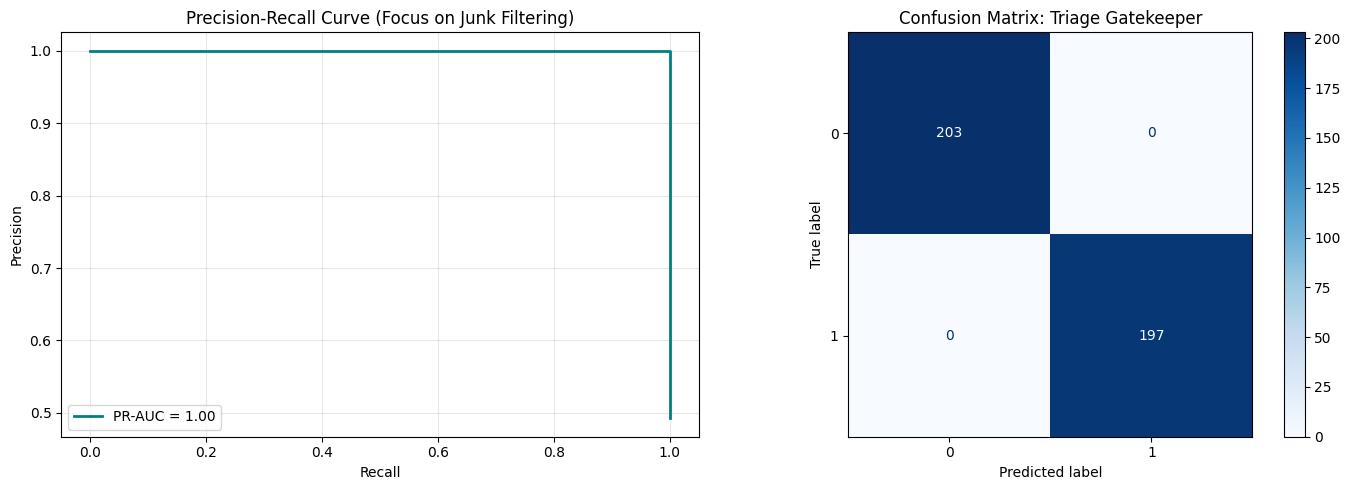

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

#Precision-Recall Curve

ax[0].plot(recall, precision, label=f'PR-AUC = {pr_auc_score:.2f}', color='teal', lw=2)
ax[0].set_title('Precision-Recall Curve (Focus on Junk Filtering)')
ax[0].set_xlabel('Recall')
ax[0].set_ylabel('Precision')
ax[0].legend()
ax[0].grid(alpha=0.3)

#Confusion Matrix

ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, cmap='Blues', ax=ax[1])
ax[1].set_title('Confusion Matrix: Triage Gatekeeper')

plt.tight_layout()
plt.show()

In [11]:
print("\n" + "="*50)
print("FINAL PIPELINE REPORT")
print("="*50)
print(classification_report(y_test, pipeline.predict(X_test), target_names=['Junk', 'High-Value']))



FINAL PIPELINE REPORT
              precision    recall  f1-score   support

        Junk       1.00      1.00      1.00       203
  High-Value       1.00      1.00      1.00       197

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



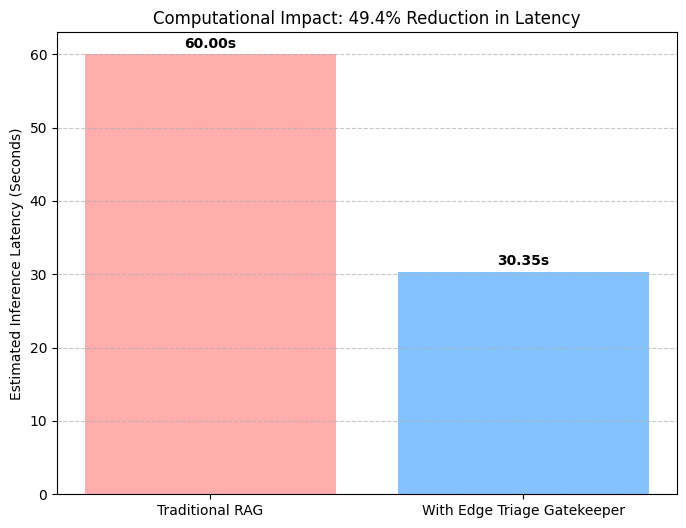

Impact Summary: The triage layer filtered 203 junk documents.
Total time saved for 400 documents: 29.65 seconds.


In [12]:
import matplotlib.pyplot as plt
import numpy as np

llm_embedding_latency_ms = 150
triage_latency_ms = 2
total_docs = len(y_test)
docs_filtered = (pipeline.predict(X_test) == 0).sum()
docs_passed = total_docs - docs_filtered

traditional_time = total_docs * llm_embedding_latency_ms
triage_system_time = (total_docs * triage_latency_ms) + (docs_passed * llm_embedding_latency_ms)
savings_percent = (1 - (triage_system_time / traditional_time)) * 100

labels = ['Traditional RAG', 'With Edge Triage Gatekeeper']
times = [traditional_time / 1000, triage_system_time / 1000]

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, times, color=['#ff9999', '#66b3ff'], alpha=0.8)
plt.ylabel('Estimated Inference Latency (Seconds)')
plt.title(f'Computational Impact: {savings_percent:.1f}% Reduction in Latency')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.2f}s', ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(f"Impact Summary: The triage layer filtered {docs_filtered} junk documents.")
print(f"Total time saved for {total_docs} documents: {(traditional_time - triage_system_time)/1000:.2f} seconds.")